<a href="https://colab.research.google.com/github/juliuswiscmsba/Birth-Prediction/blob/main/Birth_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
from google.colab import files
df = files.upload()

Saving BirthR.csv to BirthR.csv


In [103]:
df = pd.read_csv('BirthR.csv')

In [43]:
df.tail()

,births,year,month,date_of_month,day_of_week
Date,,,,,
2014-12-27,8656,2014,12,27,6
2014-12-28,7724,2014,12,28,7
2014-12-29,12811,2014,12,29,1
2014-12-30,13634,2014,12,30,2
2014-12-31,11990,2014,12,31,3


In [6]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

In [7]:
df.head()

,births,year,month,date_of_month,day_of_week
Date,,,,,
1994-01-01,8096,1994,1,1,6
1994-01-02,7772,1994,1,2,7
1994-01-03,10142,1994,1,3,1
1994-01-04,11248,1994,1,4,2
1994-01-05,11053,1994,1,5,3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7670 entries, 1994-01-01 to 2014-12-31
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   births         7670 non-null   int64
 1   year           7670 non-null   int64
 2   month          7670 non-null   int64
 3   date_of_month  7670 non-null   int64
 4   day_of_week    7670 non-null   int64
dtypes: int64(5)
memory usage: 359.5 KB


In [9]:
df.isna().any()

births           False
year             False
month            False
date_of_month    False
day_of_week      False
dtype: bool

Data Visualization

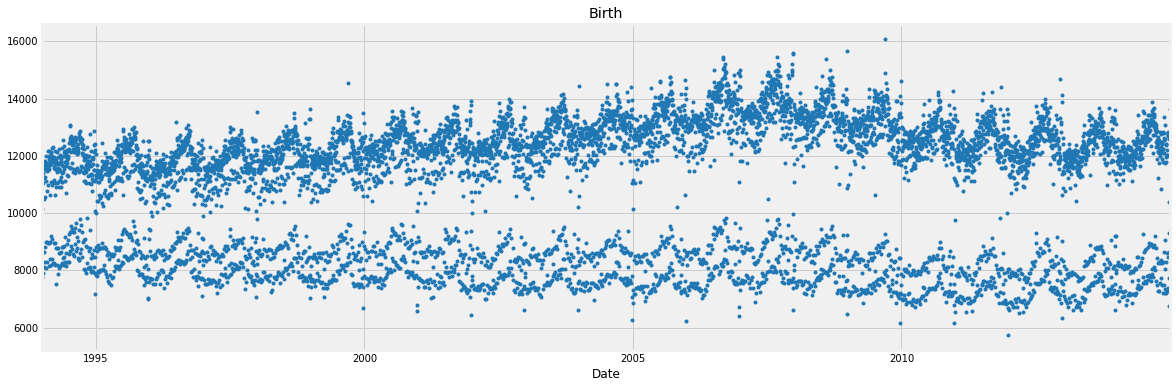

In [11]:
df['births'].plot(style='.', figsize=(18,6), color=color_pal[0], title='Birth')

In [17]:
df_years = df.loc[(df.index > '2000-01-01') & (df.index < '2001-01-01')]

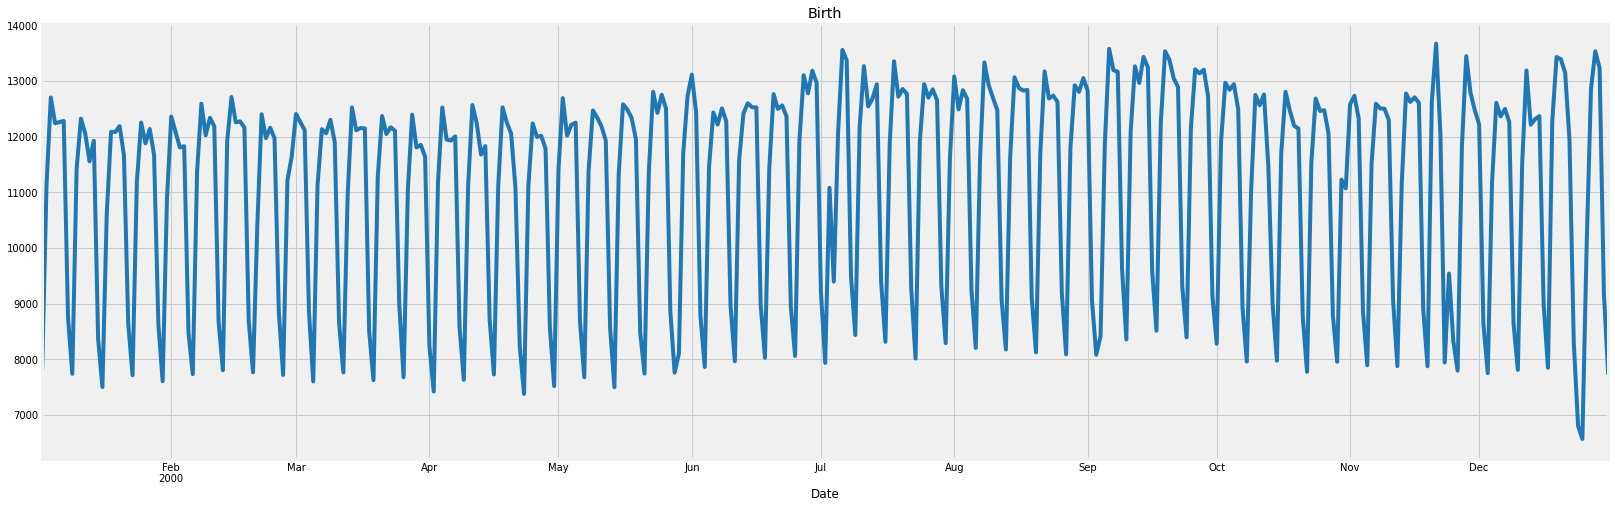

In [21]:
df_years['births'].plot(style='-', figsize=(25,8), color=color_pal[0], title='Birth')

From the line chart, it shows that there are two peaks every week.

In [22]:
df.columns

Index(['births', 'year', 'month', 'date_of_month', 'day_of_week'], dtype='object')

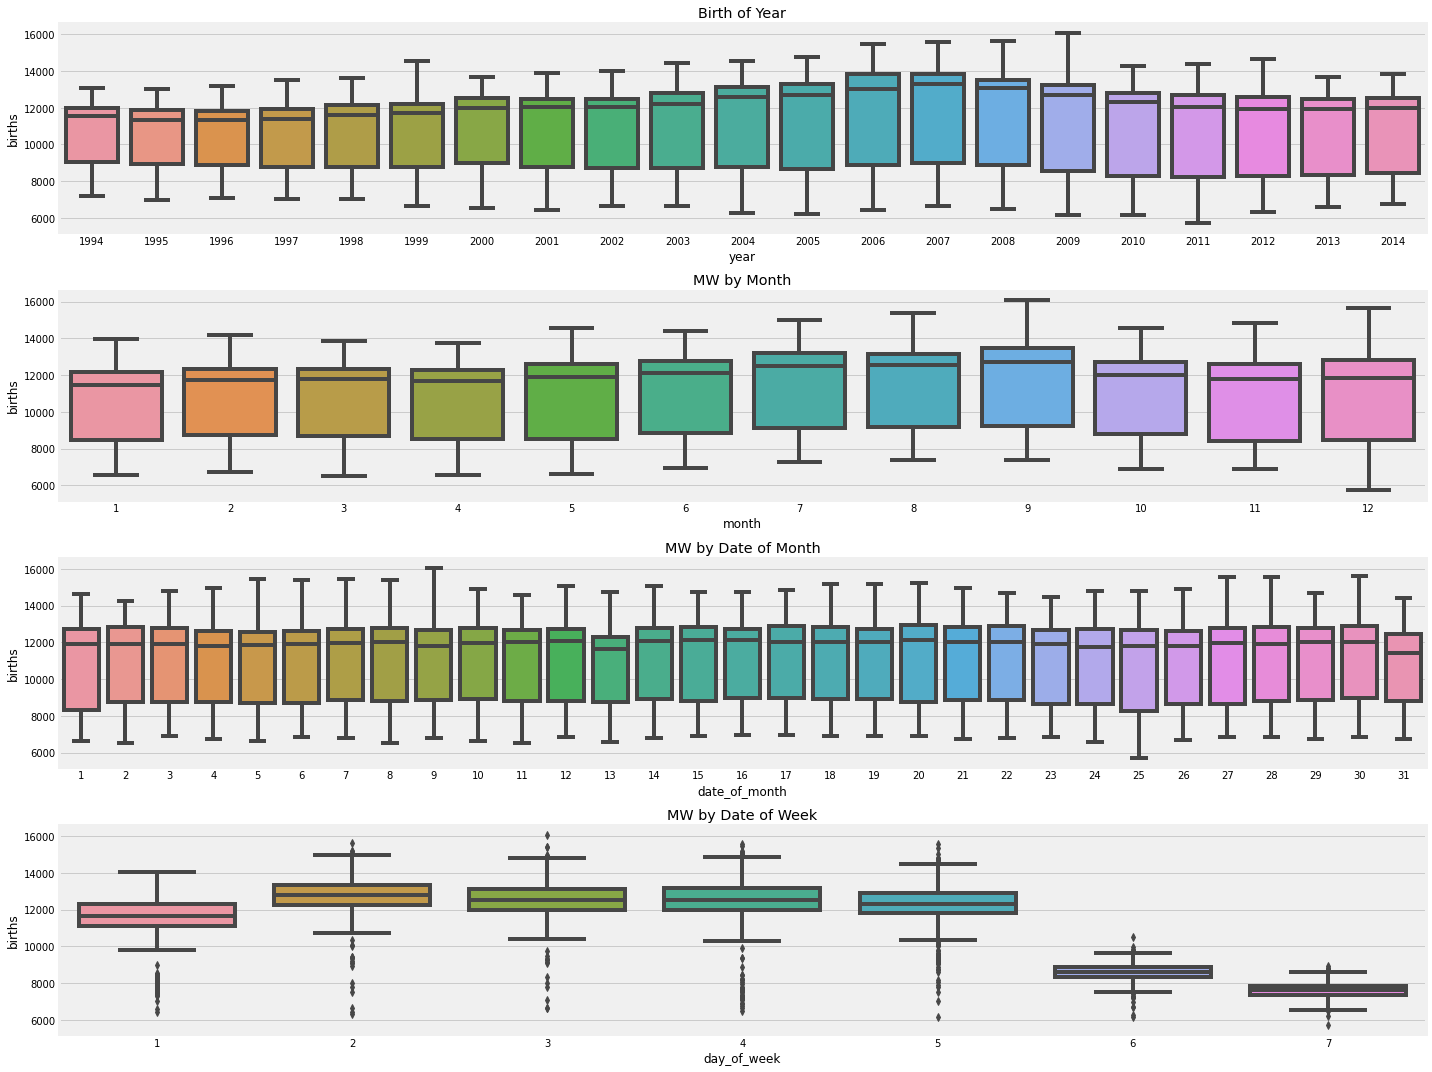

In [25]:
fig, ax = plt.subplots(4,1,figsize=(20,15))
sns.boxplot(data=df, x='year', y='births', ax=ax[0])
ax[0].set_title('Birth of Year')
sns.boxplot(data=df, x='month', y='births', ax=ax[1])
ax[1].set_title('MW by Month')
sns.boxplot(data=df, x='date_of_month', y='births', ax=ax[2])
ax[2].set_title('MW by Date of Month')
sns.boxplot(data=df, x='day_of_week', y='births', ax=ax[3])
ax[3].set_title('MW by Date of Week')
fig.tight_layout()
plt.show()

From the charts, I found some interesting findings.

1. The first chart (year) shows that 2007 was a peak, meaning that before 2007, more and more people were born every year. However, after 2007, fewer people were born every year.

2. The second chart (month) shows that most people are born in July, August, and September. If we would like to sell baby-related products, we can increase the number of our ads before July.

3. In the third chart (date of month), there is no big difference between each day except for the thirteenth. The reason may be that some consider the number 13 as an unlucky number.

4. The last chart (day of week) shows most people were born on weekdays. The reason may be that there are fewer doctors at the hospital during the weekend, as a result, they prefer to arrange the caesarean section on weekdays.

Stationary Check

In [136]:
from statsmodels.tsa.stattools import adfuller
X= df.births.values
result=adfuller(X)
print('ADF Statistics:%f'%result[0])
print('p-value:%f'%result[1])
print('critical values')
for key,value in result[4].items():
    print('\t%s: %.3f'%(key,value))

ADF Statistics:-4.085969
p-value:0.001022
critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567


Prepare for RNN model

In [147]:
df_scaler = pd.DataFrame(df['births'])

In [148]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

X=scaler.fit_transform(df_scaler)

X

array([[-1.39785196],
       [-1.54700558],
       [-0.45597447],
       ...,
       [ 0.7727015 ],
       [ 1.15157011],
       [ 0.39475359]])

In [149]:
X_all=[]
y_all=[]

past=20
future=100

for i in range(past, len(X)-future+1):
  X_all.append(X[i-past:i])
  y_all.append(X[i+future-1:i+future])

X_all = np.array(X_all)
y_all = np.array(y_all)
X_train = X_all[:6500]
y_train = y_all[:6500]
X_test = X_all[6500:]
y_test = y_all[6500:]

In [150]:
n_feature=1
X_all = X_all.reshape(X_all.shape[0],X_all.shape[1],n_feature)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],n_feature)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],n_feature)

In [151]:
X_all.shape, X_train.shape, X_test.shape

((7551, 20, 1), (6500, 20, 1), (1051, 20, 1))

Train model

In [152]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.metrics.metrics import activations

In [153]:
model=Sequential()

model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=((X_all.shape[1], X_all.shape[2]))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(5e-4),loss='mse')
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirecti  (None, 20, 128)          33792     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 20, 128)           0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dense_14 (Dense)            (None, 1)               

In [154]:
history=model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
204/204 [==============================] - 23s 19ms/step - loss: 0.4726 - val_loss: 0.2629
Epoch 2/50
204/204 [==============================] - 2s 12ms/step - loss: 0.2283 - val_loss: 0.2199
Epoch 3/50
204/204 [==============================] - 2s 12ms/step - loss: 0.2031 - val_loss: 0.2142
Epoch 4/50
204/204 [==============================] - 2s 12ms/step - loss: 0.1916 - val_loss: 0.2015
Epoch 5/50
204/204 [==============================] - 3s 15ms/step - loss: 0.1840 - val_loss: 0.2285
Epoch 6/50
204/204 [==============================] - 2s 12ms/step - loss: 0.1776 - val_loss: 0.1940
Epoch 7/50
204/204 [==============================] - 2s 12ms/step - loss: 0.1740 - val_loss: 0.1826
Epoch 8/50
204/204 [==============================] - 2s 12ms/step - loss: 0.1658 - val_loss: 0.1923
Epoch 9/50
204/204 [==============================] - 2s 12ms/step - loss: 0.1617 - val_loss: 0.1866
Epoch 10/50
204/204 [==============================] - 2s 12ms/step - loss: 0.1596 - val_l

Model evaluation

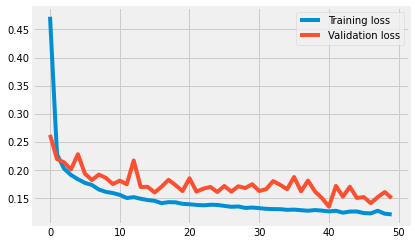

In [155]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [156]:
y_pred = model.predict(X_test)

33/33 [==============================] - 1s 5ms/step


In [171]:
y_t_pred = scaler.inverse_transform(y_pred)
y_t_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0],y_test.shape[1]))

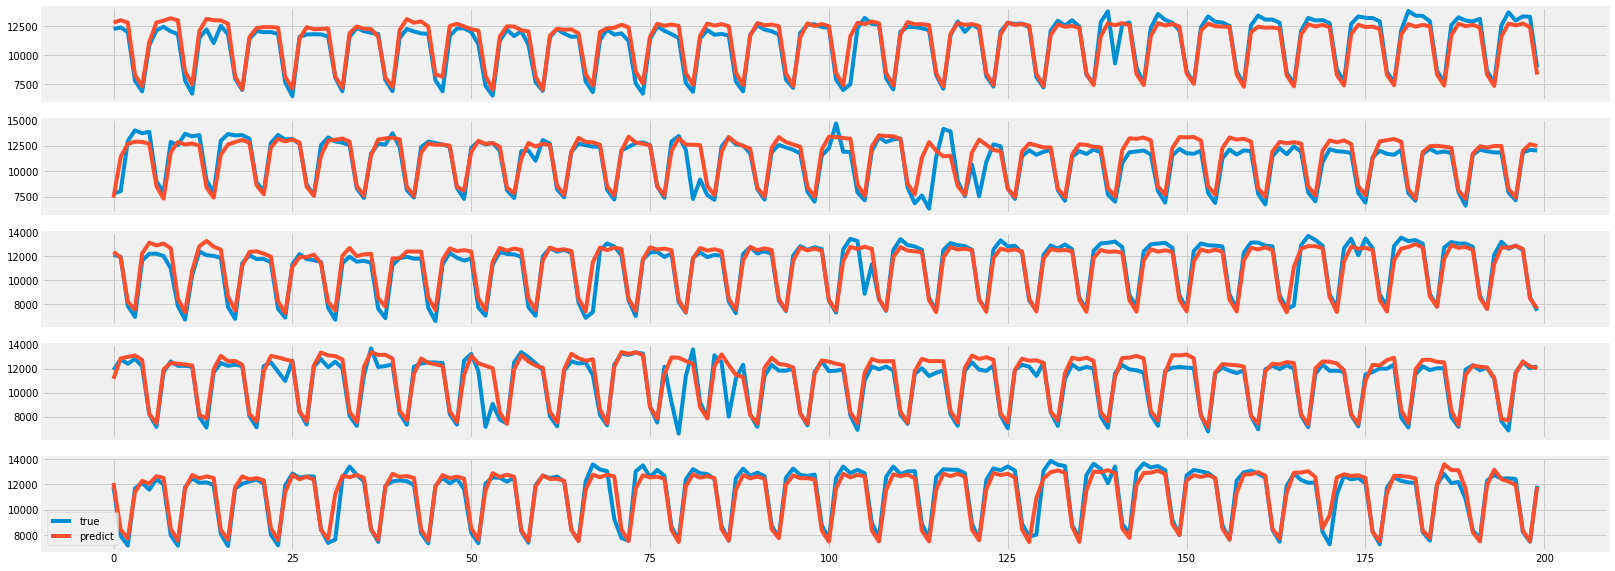

In [187]:
fig , ax = plt.subplots(5,1,figsize=(25,10), sharex=True)
ax[0].plot(y_t_test[:200], label='true', color = color_pal[0])
ax[0].plot(y_t_pred[:200], label='predict', color = color_pal[1])
ax[1].plot(y_t_test[200:400], label='true', color = color_pal[0])
ax[1].plot(y_t_pred[200:400], label='predict', color = color_pal[1])
ax[2].plot(y_t_test[400:600], label='true', color = color_pal[0])
ax[2].plot(y_t_pred[400:600], label='predict', color = color_pal[1])
ax[3].plot(y_t_test[600:800], label='true', color = color_pal[0])
ax[3].plot(y_t_pred[600:800], label='predict', color = color_pal[1])
ax[4].plot(y_t_test[800:1000], label='true', color = color_pal[0])
ax[4].plot(y_t_pred[800:1000], label='predict', color = color_pal[1])
plt.legend()
plt.show()

Train model using the whole dataset

In [189]:
model=Sequential()

model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=((X_all.shape[1], X_all.shape[2]))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(5e-4),loss='mse')
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_23 (Bidirecti  (None, 20, 128)          33792     
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 20, 128)           0         
                                                                 
 bidirectional_24 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 16)                1040      
                                                                 
 dense_16 (Dense)            (None, 1)               

In [190]:
history=model.fit(X_all, y_all, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
236/236 [==============================] - 9s 11ms/step - loss: 0.5186
Epoch 2/50
236/236 [==============================] - 3s 11ms/step - loss: 0.2721
Epoch 3/50
236/236 [==============================] - 3s 11ms/step - loss: 0.2245
Epoch 4/50
236/236 [==============================] - 3s 11ms/step - loss: 0.2067
Epoch 5/50
236/236 [==============================] - 3s 13ms/step - loss: 0.1966
Epoch 6/50
236/236 [==============================] - 3s 11ms/step - loss: 0.1887
Epoch 7/50
236/236 [==============================] - 3s 11ms/step - loss: 0.1816
Epoch 8/50
236/236 [==============================] - 3s 11ms/step - loss: 0.1754
Epoch 9/50
236/236 [==============================] - 3s 11ms/step - loss: 0.1687
Epoch 10/50
236/236 [==============================] - 3s 11ms/step - loss: 0.1668
Epoch 11/50
236/236 [==============================] - 3s 11ms/step - loss: 0.1604
Epoch 12/50
236/236 [==============================] - 3s 11ms/step - loss: 0.1577
Epoch 13/50
2

Predict the birth of the next 100 days

In [191]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [198]:
predict_period_dates = pd.date_range(list(df['Date'])[-past], periods=future, freq=us_bd).tolist()

In [200]:
prediction = model.predict(X_all[-future:])

4/4 [==============================] - 3s 7ms/step


In [206]:
y_pred_future = scaler.inverse_transform(prediction)[:,0]

In [208]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'births':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

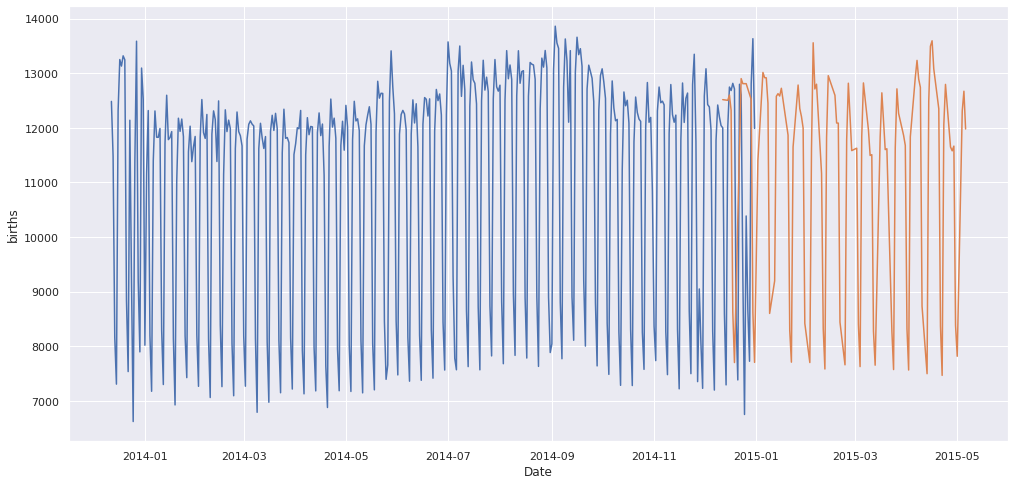

In [214]:
original = df[['Date', 'births']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2013-12-12']

sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(original['Date'], original['births'])
sns.lineplot(df_forecast['Date'], df_forecast['births'])